## This script makes figures using the output of motor_pipeline.ipynb

### Import Packages

In [28]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import ttest_ind

### Define Paths and Variables

In [87]:
grp_df = pd.read_csv('grp_df_3T_SOBP_trimmed_with_extras.csv')
diag_df = pd.read_csv('diag_df_3T_SOBP.csv')

# Choose what to analyse
networks = ["Default","SomMot"] 
#network = "SomMot"
CESTnetworks = ["avgCEST_Default", "ctCEST_Default","avgCEST_SomMot", "ctCEST_SomMot"]
CNB_scores = ["tap_tot"]
CNB_valids = ["tap_valid"] 
diag_scores = ["hstatus"]
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
covariate_age = 'age' 
covariate_sex = 'sex'

### Data Trimming

In [89]:
# Standardize groups and keep only PSD or healthy

grp_df['hstatus'] = grp_df['hstatus'].replace('NC', 'HC')
grp_df['hstatus'] = grp_df['hstatus'].replace('PROR', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('PRO', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('S', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('O', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('Unknown', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('MDD', 'Other')

#Trim NaNs and by diagnosis; rename sex variable.
#grp_df = grp_df.dropna(subset=['avgCEST_SomMot', 'SomMot', 'hstatus']) #
#grp_df = grp_df[grp_df['hstatus'] != 'Other']
grp_df['sex'] = np.where(grp_df['sex'] == 1, 'M', 'F')

#Exclude tap-tot outliers, which are >2.5 standard deviations from the mean.
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]
#Exclude FC outlier
grp_df = grp_df[grp_df['SomMot'] > 0.2]
#Exclude Other diagnostic group
grp_df = grp_df[grp_df['hstatus'] != 'Other']


value_counts = grp_df['hstatus'].value_counts() 

print(value_counts)
#print(grp_df)
grp_df.to_csv('grp_df_3T.csv', index=True)

hstatus
PSY    42
HC     26
Name: count, dtype: int64


### Subjects Excluded:

Only 4 people in other group. Given reviews on meta-analysis and small "Other" sample, exclude from present analysis.
Exclude outliers for taptot (i.e. >2.5 sd from sample mean of 106)
Excluded outlier with very low SomMot fc.



### Demographics

In [91]:
# Exclude missing values
grp_df = grp_df.dropna(subset=['age'])
grp_df = grp_df[grp_df['age'] != 'Unknown']
grp_df['age'] = pd.to_numeric(grp_df['age'], errors='coerce')

# W
grp_df_PSY = grp_df[grp_df['hstatus']=='PSY']
grp_df_HC = grp_df[grp_df['hstatus']=='HC']


# Age
age_mean_sd_all = grp_df['age'].mean(), grp_df['age'].std(), grp_df['age'].mode(), grp_df['age'].median()
age_grps = grp_df.groupby("hstatus").agg(
    Age_avg = ("age", "mean"),
    Age_std = ("age", "std"))
age_t, age_p = scipy.stats.ttest_ind(grp_df_PSY['age'],grp_df_HC['age'])
# Sex
sex_counts = grp_df.groupby('hstatus')['sex'].value_counts() 
total_f = sex_counts.loc(axis=0)[:, 'F'].sum()
#sex_t, sex_p = scipy.stats.ttest_ind(grp_df_PSY['sex'],grp_df_HC['sex'])
# CEST
cest_mean_sd_all = grp_df['avgCEST_SomMot'].mean(), grp_df['avgCEST_SomMot'].std(), grp_df['avgCEST_SomMot'].mode(), grp_df['avgCEST_SomMot'].median()
cest_grps = grp_df.groupby("hstatus").agg(
    cest_avg = ("avgCEST_SomMot", "mean"),
    cest_std = ("avgCEST_SomMot", "std"))
cest_t, cest_p = scipy.stats.ttest_ind(grp_df_PSY['avgCEST_SomMot'],grp_df_HC['avgCEST_SomMot'])
# FC
fc_mean_sd_all = grp_df['SomMot'].mean(), grp_df['SomMot'].std(), grp_df['SomMot'].mode(), grp_df['SomMot'].median()
fc_grps = grp_df.groupby("hstatus").agg(
    fc_avg = ("SomMot", "mean"),
    fc_std = ("SomMot", "std"))
fc_t, fc_p = scipy.stats.ttest_ind(grp_df_PSY['SomMot'],grp_df_HC['SomMot'])
# Tap_tot
grp_df_PSY = grp_df_PSY.dropna(subset='tap_tot')
grp_df_HC.dropna(subset='tap_tot')

tap_mean_sd_all = grp_df['tap_tot'].mean(), grp_df['tap_tot'].std()
tap_grps = grp_df.groupby("hstatus").agg(
    tap_avg = ("tap_tot", "mean"),
    tap_std = ("tap_tot", "std"))
tap_t, tap_p = scipy.stats.ttest_ind(grp_df_PSY['tap_tot'],grp_df_HC['tap_tot'])

race_counts = grp_df.groupby('hstatus')['race'].value_counts()    


# Table 1 of manuscript should have:
# Average age (SD)
# Male/female
# Tap_tot scores
# Racial demographics
# Medications?
# Comorbidities

columns = ['Whole sample', 'PSY', 'HC', 'T test (p value)']


demographics_table = pd.DataFrame({
    columns[0]: [f"{age_mean_sd_all[0]:.2f} ({age_mean_sd_all[1]:.2f})",
                 f"{total_f} ({total_f/sex_counts.sum():.2f})",
                 f"{tap_mean_sd_all[0]:.2f} ({tap_mean_sd_all[1]:.2f})",
                 f"{cest_mean_sd_all[0]:.2f} ({cest_mean_sd_all[1]:.2f})",
                 f"{fc_mean_sd_all[0]:.2f} ({fc_mean_sd_all[1]:.2f})"],
    
    columns[1]: [f"{age_grps.loc['PSY', 'Age_avg']:.2f} ({age_grps.loc['PSY', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('PSY', 'F')]} ({sex_counts.loc[('PSY', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['PSY', 'tap_avg']:.2f} ({tap_grps.loc['PSY', 'tap_std']:.2f})",
                 f"{cest_grps.loc['PSY', 'cest_avg']:.2f} ({cest_grps.loc['PSY', 'cest_std']:.2f})",
                 f"{fc_grps.loc['PSY', 'fc_avg']:.2f} ({fc_grps.loc['PSY', 'fc_std']:.2f})"],
    
    columns[2]: [f"{age_grps.loc['HC', 'Age_avg']:.2f} ({age_grps.loc['HC', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('HC', 'F')]} ({sex_counts.loc[('HC', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['HC', 'tap_avg']:.2f} ({tap_grps.loc['HC', 'tap_std']:.2f})",
                 f"{cest_grps.loc['HC', 'cest_avg']:.2f} ({cest_grps.loc['HC', 'cest_std']:.2f})",
                 f"{fc_grps.loc['HC', 'fc_avg']:.2f} ({fc_grps.loc['HC', 'fc_std']:.2f})"],

    columns[3]: [f"{round(age_t, 2):.2f} ({round(age_p, 2):.2f})",
                 "",#f"{round(sex_t, 2):.2f} ({round(sex_p, 2):.2f})",
                 f"{round(tap_t, 2):.2f} ({round(tap_p, 2):.2f})",
                 f"{round(cest_t, 2):.2f} ({round(cest_p, 2):.2f})",
                 f"{round(fc_t, 2):.2f} ({round(fc_p, 2):.2f})",],

                 }, index=['Age (SD)', 'Sex (%)', 'Tapping Score avg (SD)', 'Avg SomMot GluCEST (SD)', 'Avg within-SomMot FC'])

# Display the styled DataFrame
print(demographics_table)
demographics_table.to_csv('demo_table_3T_SOBP.csv', index=True)


                          Whole sample             PSY             HC  \
Age (SD)                  22.42 (2.97)    22.36 (3.27)   22.48 (2.48)   
Sex (%)                      68 (1.00)       42 (0.62)      26 (0.38)   
Tapping Score avg (SD)   108.49 (9.30)  107.16 (10.34)  110.36 (7.54)   
Avg SomMot GluCEST (SD)    7.62 (0.88)     7.55 (0.88)    7.71 (0.91)   
Avg within-SomMot FC       0.48 (0.10)     0.47 (0.09)    0.50 (0.11)   

                        T test (p value)  
Age (SD)                    -0.16 (0.88)  
Sex (%)                                   
Tapping Score avg (SD)         nan (nan)  
Avg SomMot GluCEST (SD)     -0.71 (0.48)  
Avg within-SomMot FC        -1.32 (0.19)  


### QA & Histograms

age Mean: 22.42
age Median: 22.80


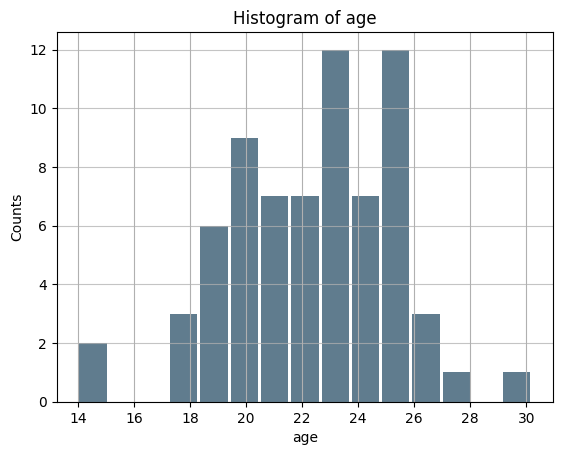

SomMot Mean: 0.48
SomMot Median: 0.48


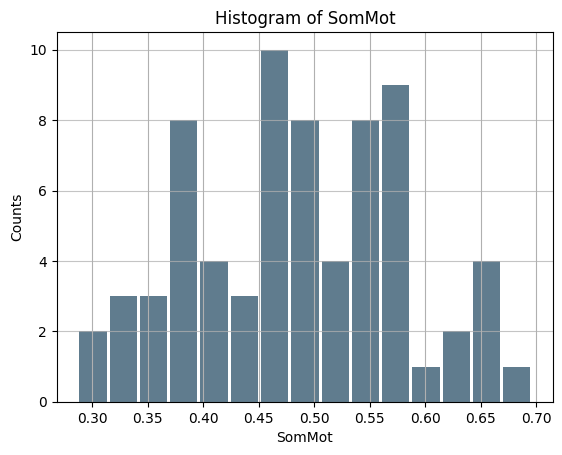

avgCEST_SomMot Mean: 7.62
avgCEST_SomMot Median: 7.70


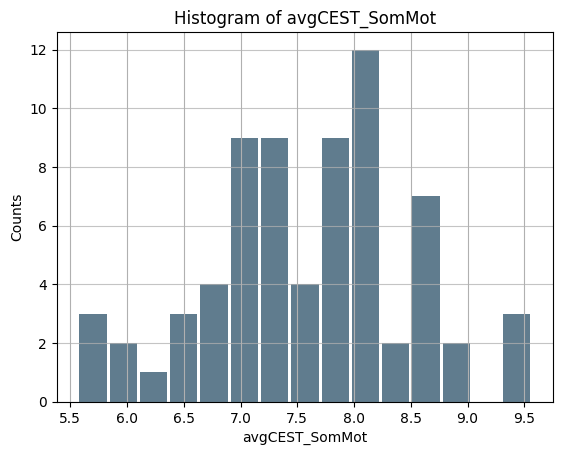

ctCEST_SomMot Mean: 47.96
ctCEST_SomMot Median: 7.70


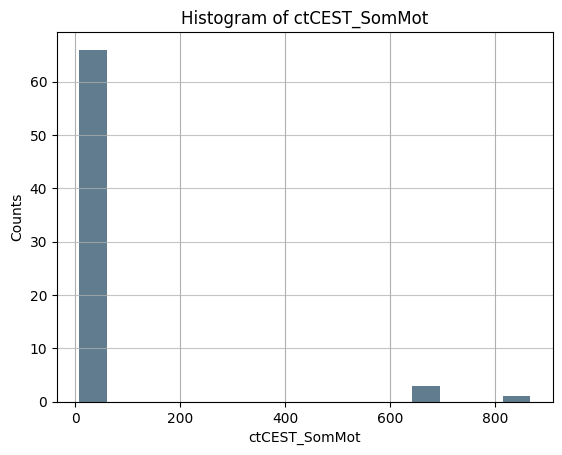

In [92]:
vars = ['age', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot']
for var in vars:
    # QA: Compare mean and median to see if distribution is roughly normal. Visualize mode in histograms.
    mm_df = grp_df[var].mean(), grp_df[var].median()
    print(var + " Mean: " + f"{mm_df[0]:.2f}")
    print(var + " Median: " + f"{mm_df[1]:.2f}")
    
    # Make histogram
    plt.figure()
    input = pd.Series(grp_df[var])
    input.plot.hist(grid=True, bins=15, rwidth=0.9, color='#607c8e')
    plt.title('Histogram of ' + var)
    plt.xlabel(var)
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

### Assess Demographic Variables

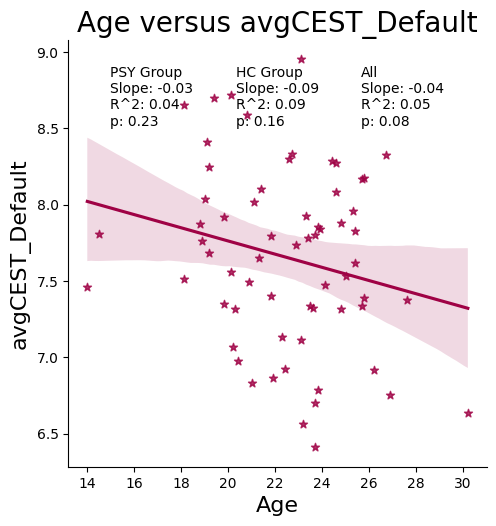

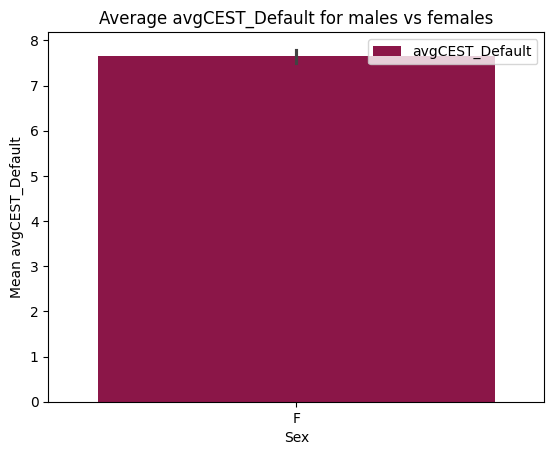

avgCEST_Defaultt test: t=nan, p=nan


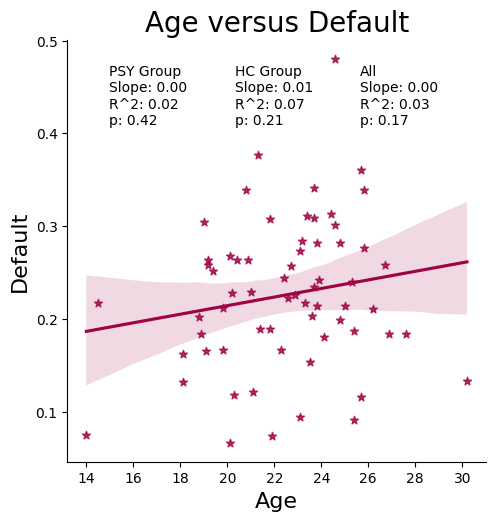

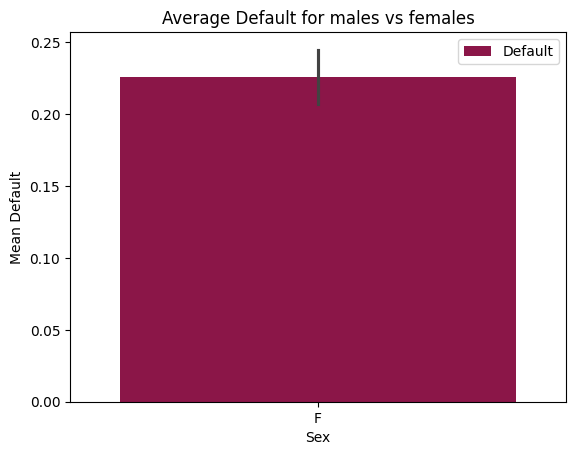

Defaultt test: t=nan, p=nan


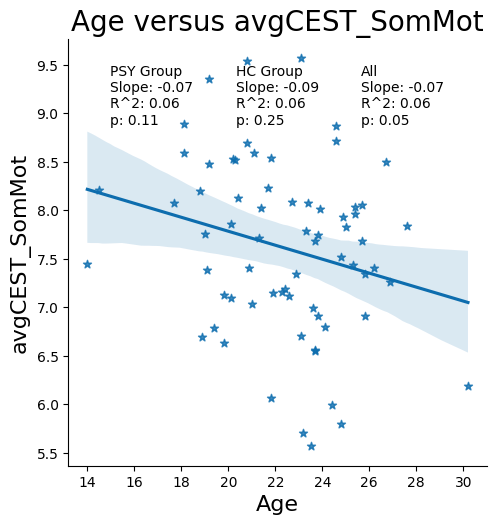

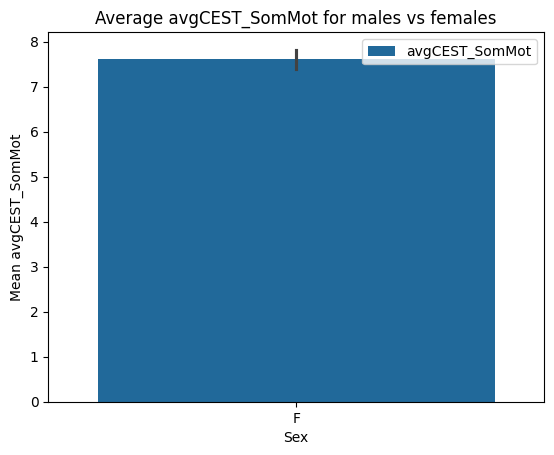

avgCEST_SomMott test: t=nan, p=nan


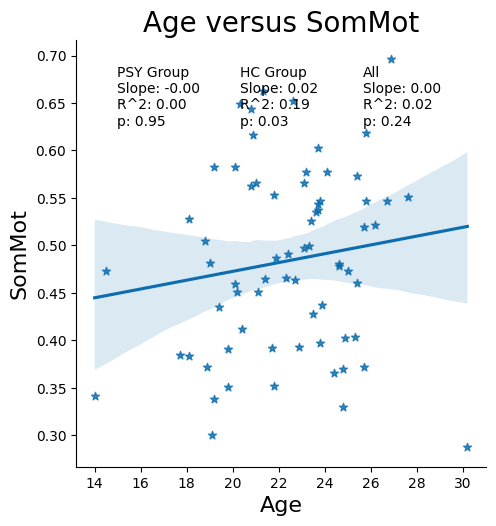

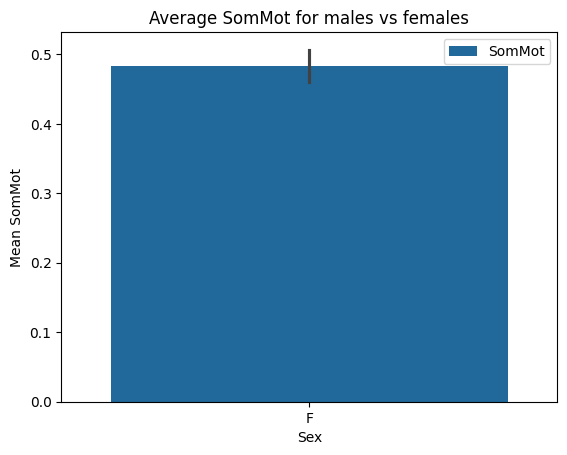

SomMott test: t=nan, p=nan


In [93]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

for network in networks:
    # Quality control figures
    #network="Vis"
    cestcol = "avgCEST_" + network
    metrics = [cestcol, network]

    for metric in metrics:
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus'])
        #print(graph_df)
        # Create a linear regression model for fcon
        color = colors.loc[colors['Network'] == network, 'Color'].values[0]
        sns.set_palette(color)
        plot = sns.lmplot(x='age', y=metric, data=graph_df, markers= "*") #hue='hstatus', 
        plt.xlabel("Age", fontsize=16)
        plt.ylabel(metric, fontsize=16)
        plt.title('Age versus ' + metric, fontsize = 20)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', 'age'], graph_df.loc[graph_df['hstatus'] == 'PSY', metric])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        #     # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', 'age'], graph_df.loc[graph_df['hstatus'] == 'HC', metric])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df['age'], graph_df[metric])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        plt.show() 

        # Bar plots assessing sex differences
        sns.barplot(x='sex', y=metric, data=graph_df, estimator='mean', label=metric) #yerr=avg_df[cestcol + '_std'],
        plt.xlabel('Sex')
        plt.ylabel('Mean ' + metric)
        plt.title('Average ' + metric + ' for males vs females')
        plt.legend()
        plt.show()
        t_statistic, p_value = ttest_ind(graph_df.loc[graph_df['sex'] == 'M', metric],
                                         graph_df.loc[graph_df['sex'] == 'F', metric])
        print(metric + 't test: t=' + str(t_statistic) + ', p=' + str(p_value))



### Main Figures

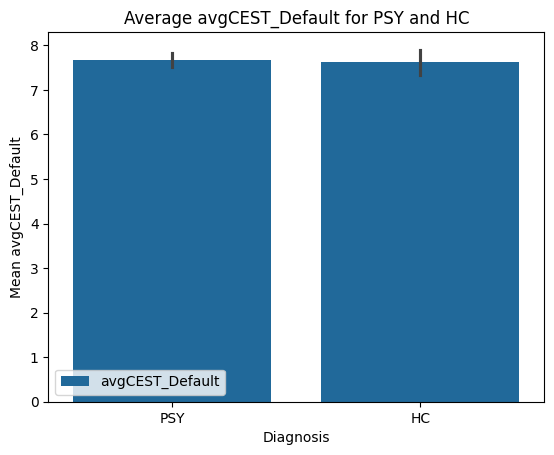

avgCEST_Defaultt test: t=nan, p=nan


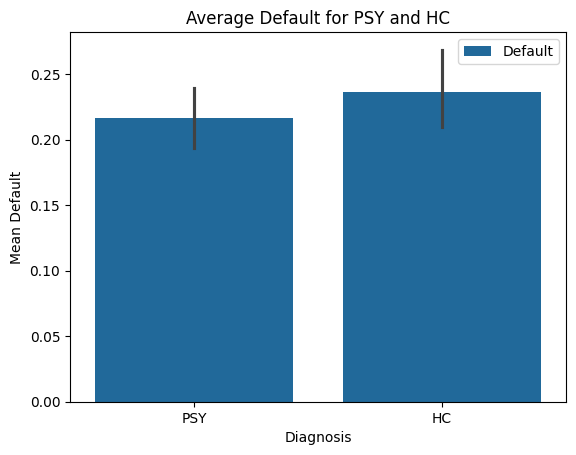

Defaultt test: t=nan, p=nan


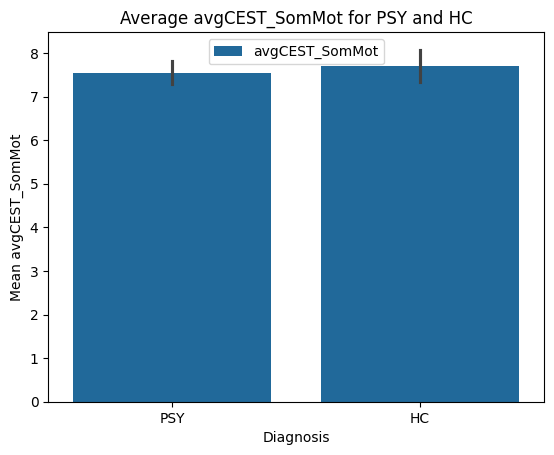

avgCEST_SomMott test: t=nan, p=nan


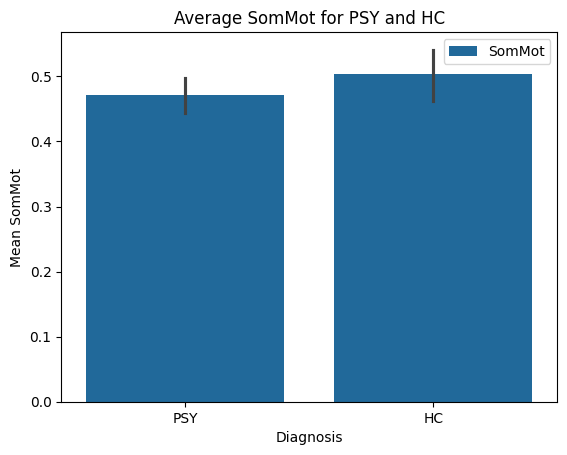

SomMott test: t=nan, p=nan


In [94]:
# Bar plots assessing sex differences
for network in networks:
    # Quality control figures
    #network="Vis"
    cestcol = "avgCEST_" + network
    metrics = [cestcol, network]

    for metric in metrics:
        sns.barplot(x='hstatus', y=metric, data=grp_df, estimator='mean', label=metric) #yerr=avg_df[cestcol + '_std'],
        plt.xlabel('Diagnosis')
        plt.ylabel('Mean ' + metric)
        plt.title('Average ' + metric + ' for PSY and HC')
        plt.legend()
        plt.show()
        t_statistic, p_value = ttest_ind(graph_df.loc[graph_df['hstatus'] == 'PSY', metric],
                                         graph_df.loc[graph_df['hstatus'] == 'F', metric])
        print(metric + 't test: t=' + str(t_statistic) + ', p=' + str(p_value))


    Unnamed: 0   BBLID  Session  SCANID_CEST sex  race  ethnic  dateDiff  \
1           51  126532    12260        12582   F   1.0     2.0      11.0   
2           30   96659    10229        11096   F   1.0     2.0       0.0   
3           70  132641     8997        10692   F   2.0     2.0       0.0   
4           79   94276    10957        10927   F   2.0     2.0       0.0   
5           76   91962  motive1        11090   F   2.0     2.0       0.0   
..         ...     ...      ...          ...  ..   ...     ...       ...   
69          72   93757    12061        12015   F   2.0     2.0       7.0   
70          12  116019    10078        11135   F   2.0     1.0       0.0   
72          18   20642    11272        11261   F   NaN     NaN       0.0   
74          39  131384    11740        12198   F   2.0     2.0       0.0   
75          69   93734    10092        10694   F   5.0     2.0       0.0   

     Default    SomMot  Cont_btwn  Default_btwn  avgCEST_Default  \
1   0.198872  0.329

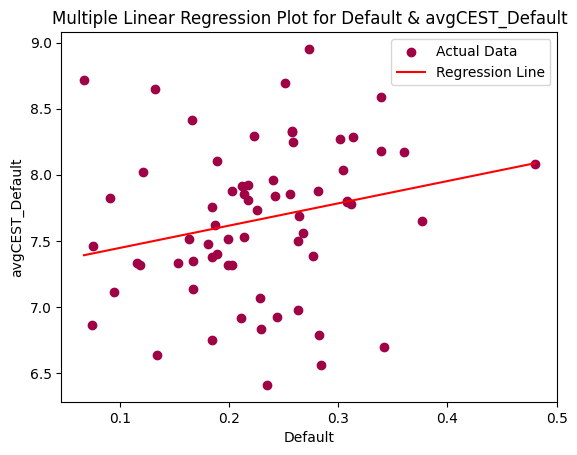

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:         avgCEST_SomMot   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.138
Date:                Fri, 26 Apr 2024   Prob (F-statistic):             0.0202
Time:                        14:34:46   Log-Likelihood:                -85.962
No. Observations:                  70   AIC:                             177.9
Df Residuals:                      67   BIC:                             184.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2403    

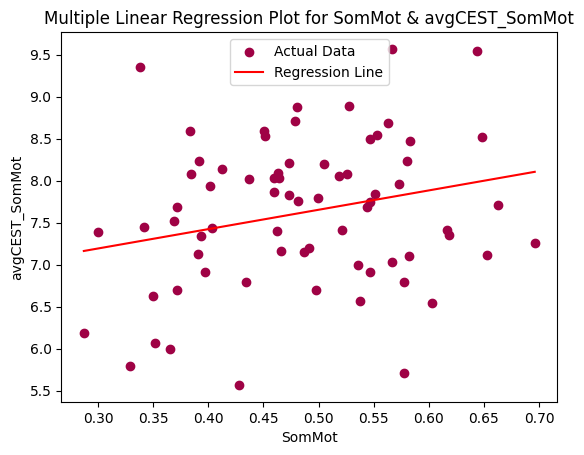

In [106]:
#print(grp_df)
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df.dropna(subset=[network, cestcol, 'hstatus'])
    #graph_df = graph_df[graph_df['hstatus']== hstatus]
    graph_df= grp_df
    #print(graph_df)
    formula = f'{cestcol} ~ {network} + {covariate_age}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('CEST-FC Association in all') 
    print(model.summary())

    fig, ax = plt.subplots()
    ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                           covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[network], y_line, color='red', label='Regression Line')
    ax.set_xlabel(network)
    ax.set_ylabel(cestcol)
    ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
    ax.legend()
    plt.show()

In [109]:

for network in networks:
    for hstatus in ["HC", "PSY"]:
        graph_df = grp_df[grp_df['hstatus']==hstatus]
        cestcol = "avgCEST_" + network
        print(graph_df)
        print(covariate_age)
        #graph_df = grp_df.dropna(subset=[network, cestcol, 'hstatus'])
        #graph_df = graph_df[graph_df['hstatus']== hstatus]
        #graph_df= grp_df
        #print(graph_df)
        covar_date = 'dateDiff'
        formula = f'{cestcol} ~ {network} + {covariate_age} + {covar_date}'
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('CEST-FC Association in ' + hstatus) 
        print('Sample size is ' + str(len(graph_df)))
        print(model.summary())
    
        fig, ax = plt.subplots()
        ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                               covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[network], y_line, color='red', label='Regression Line')
        ax.set_xlabel(network)
        ax.set_ylabel(cestcol)
        ax.set_title('Multiple Linear Regression for ' + network + ' & ' + cestcol + ' in ' + hstatus)
        ax.legend()
        plt.show()

    Unnamed: 0   BBLID  Session  SCANID_CEST sex  race  ethnic  dateDiff  \
2           30   96659    10229        11096   F   1.0     2.0       0.0   
8           28  114738    11532        11706   F   5.0     2.0       6.0   
13          46  102041    10603        10675   F   1.0     2.0       0.0   
14          40   94288    11948        12092   F   1.0     2.0      56.0   
16          82  111720    11689        11766   F   1.0     2.0      15.0   
17          77  130438    11656        11999   F   2.0     2.0      33.0   
23          41  112807    11528        11890   F   1.0     2.0      27.0   
24          61   85743    10974        10944   F   1.0     2.0       2.0   
25          14   96902    11870        11903   F   1.0     1.0       6.0   
26          78   91422  motive1        11753   F   2.0     2.0      20.0   
28          83   98370  motive2        12558   F   2.0     2.0       6.0   
29          15  118864    11724        11783   F   2.0     1.0      18.0   
31          

NameError: name 'dateDiff' is not defined

  hstatus_  avgCEST_Default_mean  avgCEST_Default_std  Default_mean  \
0       HC              7.625181             0.689641      0.236269   
1      PSY              7.670934             0.525392      0.216239   

   Default_std  
0     0.080624  
1     0.079035  


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

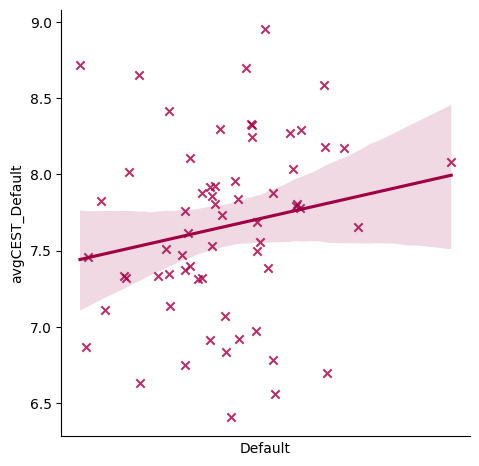

In [96]:
# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus']) #, 
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='hstatus', 
    
    # Make bar graph comparing diagnostic groups
    avg_df = grp_df.groupby('hstatus').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
    # Flatten the multi-level columns
    avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
    print(avg_df)

    
    # Plot CEST bar graph with error bars
    sns.barplot(x='hstatus_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.ylim(7, 16)
    plt.title('Average CEST for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'avgCEST_SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'avgCEST_SomMot'])
    print('CEST t test: t=' + str(t_statistic) + ', p=' + str(p_value))
    # Plot fcon bar graph with error bars
    sns.barplot(x='hstatus_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.title('Average fcon for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'SomMot'])
    print('FC t test: t=' + str(t_statistic) + ', p=' + str(p_value))


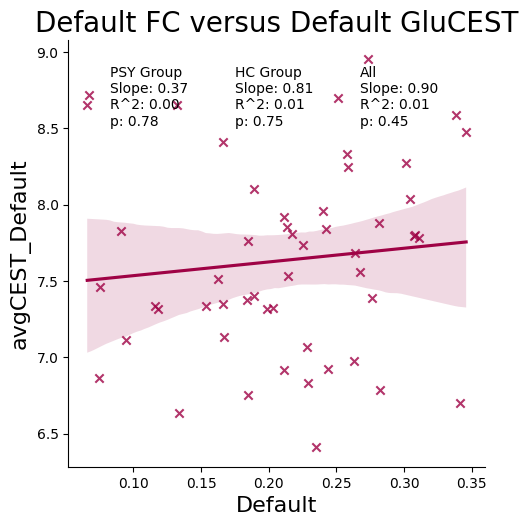

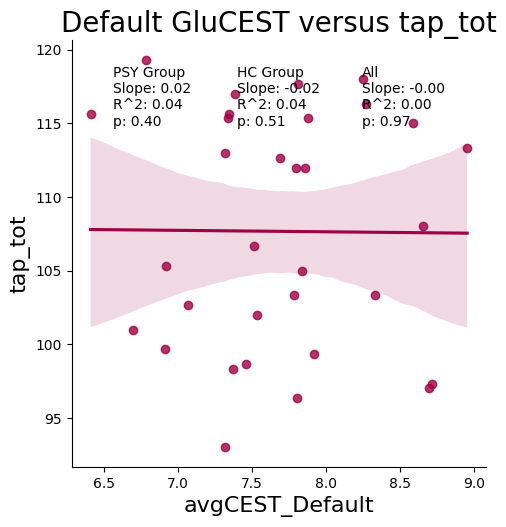

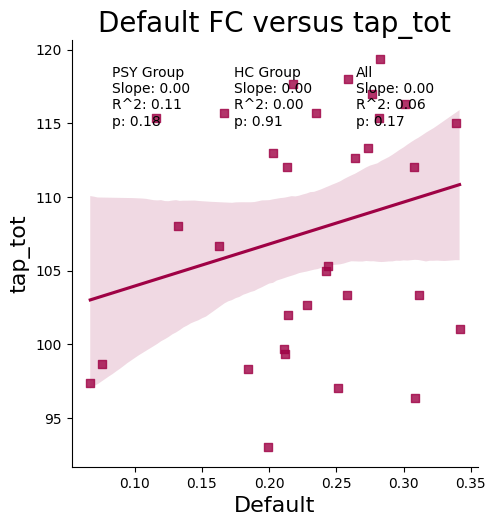

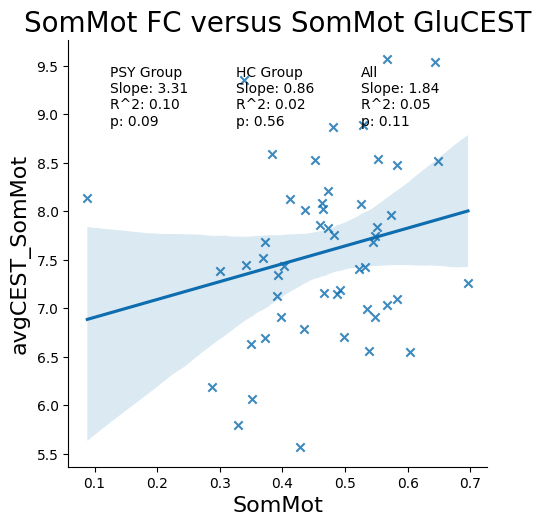

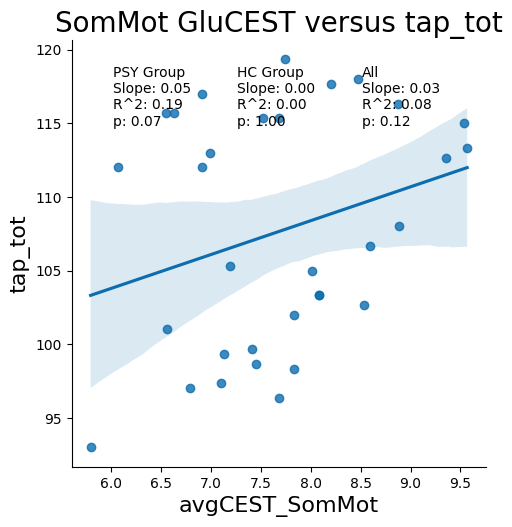

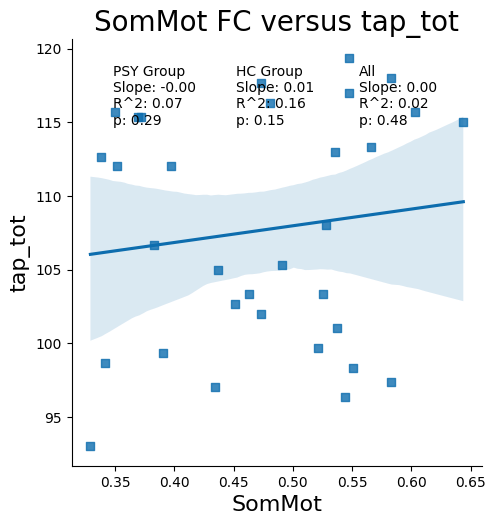

In [15]:
# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus']) #, 
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='hstatus', 
    if network == "SalVentAttn":
        plt.xlabel("SN", fontsize=16)
        plt.ylabel("avgCEST_SN", fontsize=16)
        plt.title('SN FC versus SN GluCEST', fontsize = 20)
    else:
        plt.xlabel(network, fontsize=16)
        plt.ylabel(cestcol, fontsize=16)
        plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', network], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
#     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', network], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'hstatus']) #
        # Add labels and a title to the plot
        plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("avgCEST_SN", fontsize=16)
            plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
        else: 
            plt.xlabel(cestcol, fontsize=16)
            plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()    

        #graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, network]) # 'hstatus'
        # Add labels and a title to the plot
        plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.title('SN FC versus ' + CNB_score, fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', network])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', network])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()  



### Multiple Linear Regressions

In [51]:
print(grp_df.columns)

Index(['Unnamed: 0', 'BBLID', 'Session', 'SCANID_CEST', 'sex', 'race',
       'ethnic', 'dateDiff', 'Cont', 'Default', 'DorsAttn', 'Vis',
       'SalVentAttn', 'SomMot', 'Limbic', 'Cont_btwn', 'Default_btwn',
       'DorsAttn_btwn', 'Vis_btwn', 'SalVentAttn_btwn', 'SomMot_btwn',
       'Limbic_btwn', 'avgCEST_Cont', 'ctCEST_Cont', 'avgCEST_Default',
       'ctCEST_Default', 'avgCEST_SomMot', 'ctCEST_SomMot', 'avgCEST_DorsAttn',
       'ctCEST_DorsAttn', 'avgCEST_Vis', 'ctCEST_Vis', 'avgCEST_Limbic',
       'ctCEST_Limbic', 'avgCEST_SalVentAttn', 'ctCEST_SalVentAttn', 'tap_tot',
       'volt_cr', 'volt_rtcr', 'hstatus', 'age'],
      dtype='object')


CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.267
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.296
Time:                        13:23:37   Log-Likelihood:                -121.44
No. Observations:                  34   AIC:                             248.9
Df Residuals:                      31   BIC:                             253.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     126.5158 

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'avgCEST_Vis' is not defined
    tap_tot ~ avgCEST_Vis + age
              ^^^^^^^^^^^

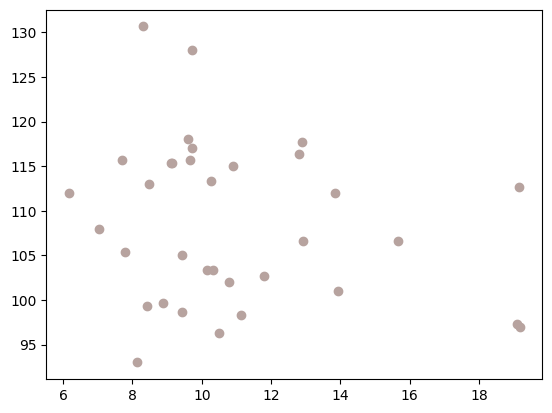

In [55]:
#for network in networks:
#    for CNB_score in CNB_scores:

network = "Vis"
cestcol = "avgCEST_" + network
graph_df=grp_df.dropna(subset=[cestcol, CNB_score])
formula = f'{CNB_score} ~ {cestcol} + {covariate_age}'
model = smf.ols(formula=formula, data=graph_df).fit()
print('CEST-FC Association in all') 
print(model.summary())

fig, ax = plt.subplots()
ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
# Generate x values for the line
x_line = pd.DataFrame({network: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                       covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
# Predictions for the regression line
y_line = model.predict(x_line)
# Plot the regression line
ax.plot(x_line[network], y_line, color='red', label='Regression Line')
ax.set_xlabel(network)
ax.set_ylabel(cestcol)
ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
ax.legend()
plt.show()

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:           avgCEST_Cont   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.102
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.338
Time:                        13:16:47   Log-Likelihood:                -53.128
No. Observations:                  70   AIC:                             112.3
Df Residuals:                      67   BIC:                             119.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6850    

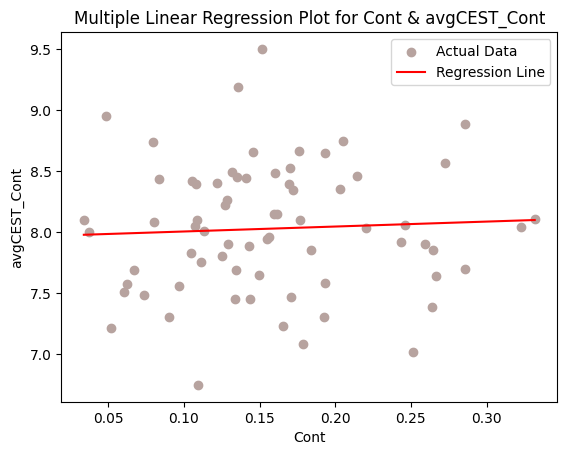

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:        avgCEST_Default   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.864
Date:                Mon, 22 Apr 2024   Prob (F-statistic):             0.0640
Time:                        13:16:47   Log-Likelihood:                -57.061
No. Observations:                  70   AIC:                             120.1
Df Residuals:                      67   BIC:                             126.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5637    

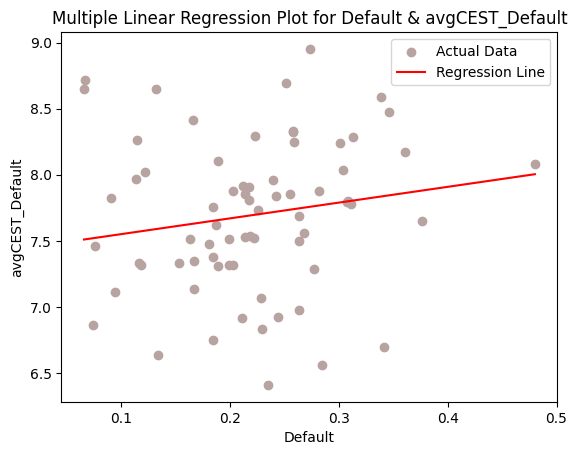

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:       avgCEST_DorsAttn   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.318
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.106
Time:                        13:16:47   Log-Likelihood:                -105.04
No. Observations:                  70   AIC:                             216.1
Df Residuals:                      67   BIC:                             222.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1285    

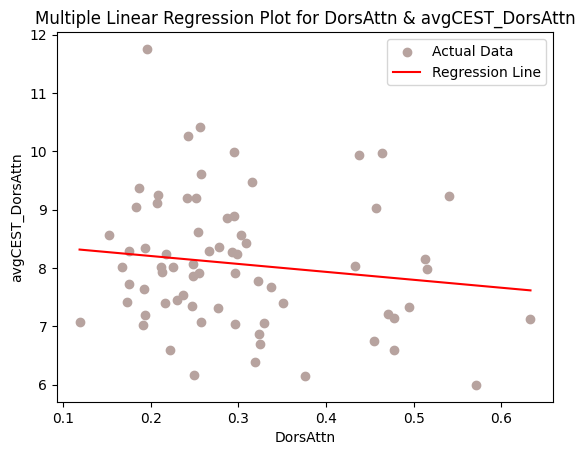

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7308
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.485
Time:                        13:16:47   Log-Likelihood:                -168.06
No. Observations:                  70   AIC:                             342.1
Df Residuals:                      67   BIC:                             348.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8160    

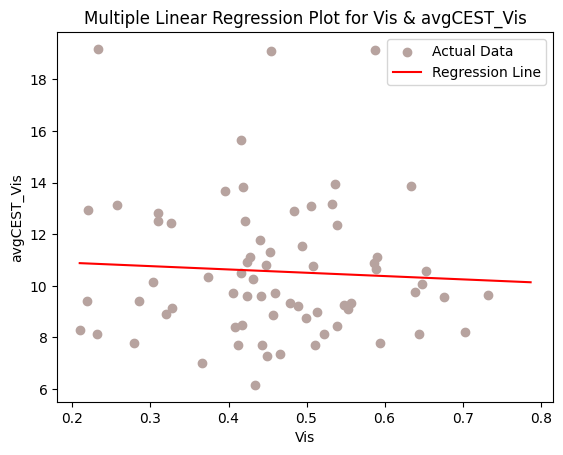

CEST-FC Association in all
                             OLS Regression Results                            
Dep. Variable:     avgCEST_SalVentAttn   R-squared:                       0.054
Model:                             OLS   Adj. R-squared:                  0.026
Method:                  Least Squares   F-statistic:                     1.904
Date:                 Mon, 22 Apr 2024   Prob (F-statistic):              0.157
Time:                         13:16:47   Log-Likelihood:                -75.093
No. Observations:                   70   AIC:                             156.2
Df Residuals:                       67   BIC:                             162.9
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    

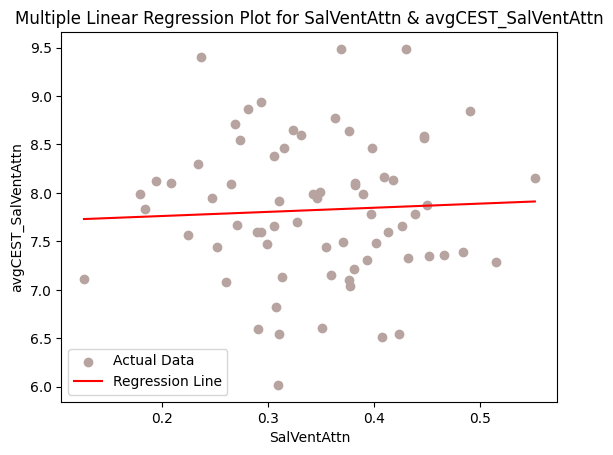

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:         avgCEST_SomMot   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.087
Date:                Mon, 22 Apr 2024   Prob (F-statistic):             0.0522
Time:                        13:16:47   Log-Likelihood:                -87.442
No. Observations:                  70   AIC:                             180.9
Df Residuals:                      67   BIC:                             187.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5393    

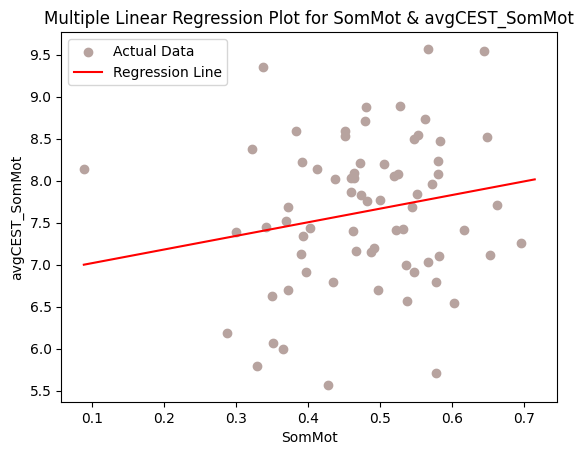

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:         avgCEST_Limbic   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.642
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.201
Time:                        13:16:47   Log-Likelihood:                -109.02
No. Observations:                  69   AIC:                             224.0
Df Residuals:                      66   BIC:                             230.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6065    

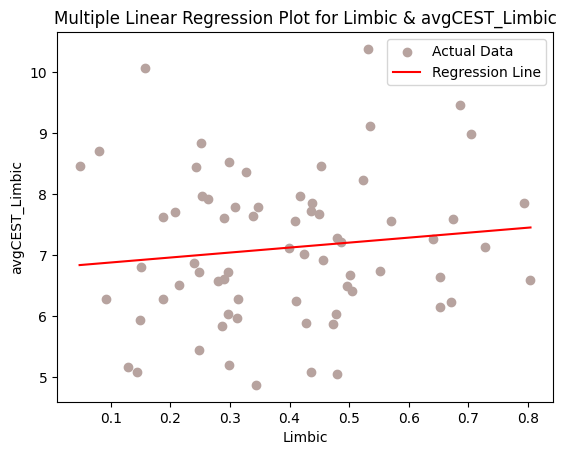

['Unnamed: 0', 'BBLID', 'Session', 'SCANID_CEST', 'sex', 'race', 'ethnic', 'dateDiff', 'Cont', 'Default', 'DorsAttn', 'Vis', 'SalVentAttn', 'SomMot', 'Limbic', 'Cont_btwn', 'Default_btwn', 'DorsAttn_btwn', 'Vis_btwn', 'SalVentAttn_btwn', 'SomMot_btwn', 'Limbic_btwn', 'avgCEST_Cont', 'ctCEST_Cont', 'avgCEST_Default', 'ctCEST_Default', 'avgCEST_SomMot', 'ctCEST_SomMot', 'avgCEST_DorsAttn', 'ctCEST_DorsAttn', 'avgCEST_Vis', 'ctCEST_Vis', 'avgCEST_Limbic', 'ctCEST_Limbic', 'avgCEST_SalVentAttn', 'ctCEST_SalVentAttn', 'tap_tot', 'volt_cr', 'volt_rtcr', 'hstatus', 'age']
is panda
CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7308
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.4

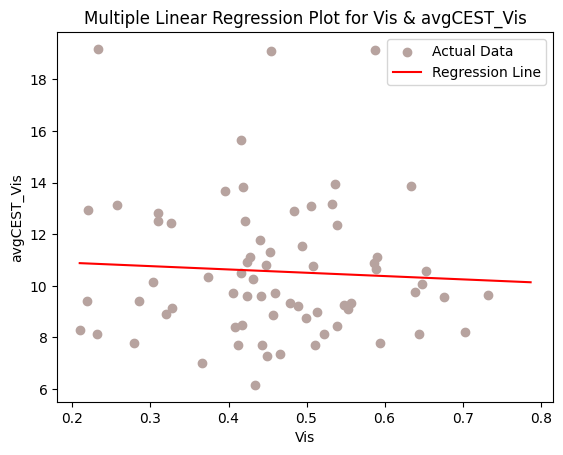

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6538
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.523
Time:                        13:13:03   Log-Likelihood:                -168.14
No. Observations:                  70   AIC:                             342.3
Df Residuals:                      67   BIC:                             349.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.2314    

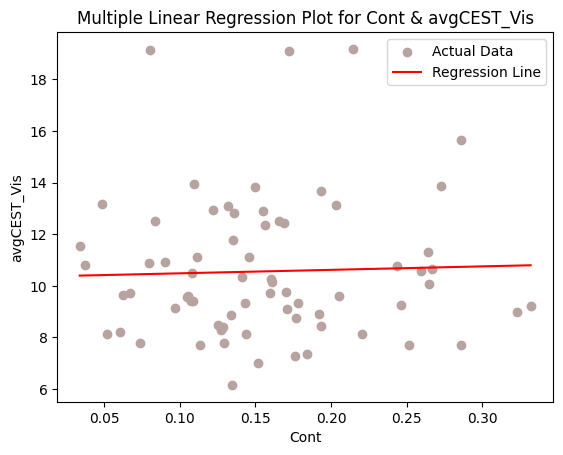

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6957
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.502
Time:                        13:13:03   Log-Likelihood:                -168.10
No. Observations:                  70   AIC:                             342.2
Df Residuals:                      67   BIC:                             348.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1773    

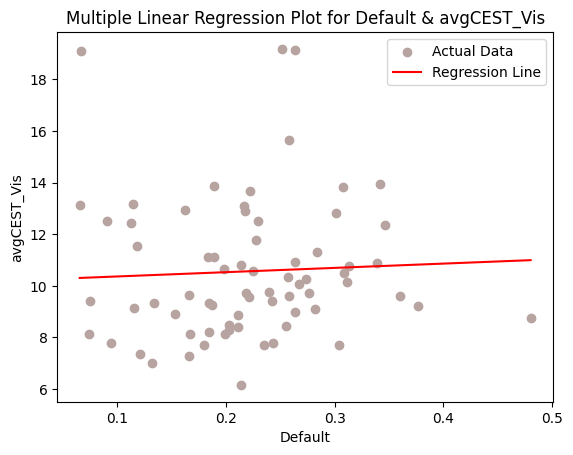

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.664
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.197
Time:                        13:13:03   Log-Likelihood:                -167.12
No. Observations:                  70   AIC:                             340.2
Df Residuals:                      67   BIC:                             347.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9260    

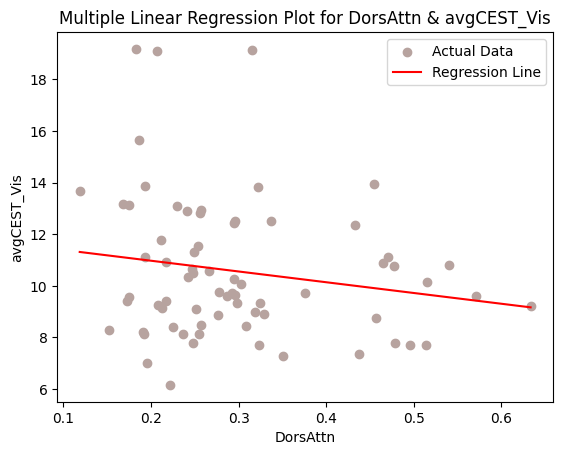

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7308
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.485
Time:                        13:13:04   Log-Likelihood:                -168.06
No. Observations:                  70   AIC:                             342.1
Df Residuals:                      67   BIC:                             348.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8160    

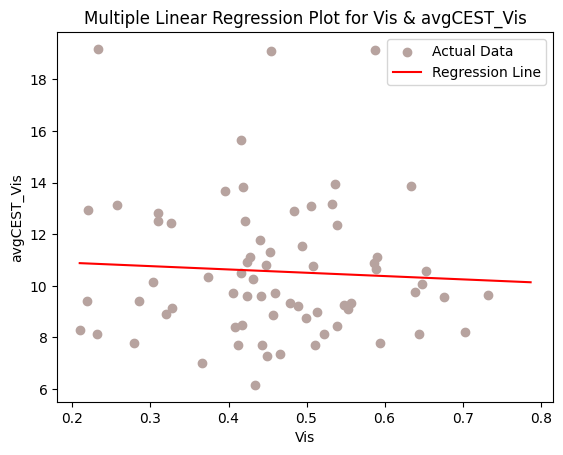

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.6275
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.537
Time:                        13:13:04   Log-Likelihood:                -168.17
No. Observations:                  70   AIC:                             342.3
Df Residuals:                      67   BIC:                             349.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.2427 

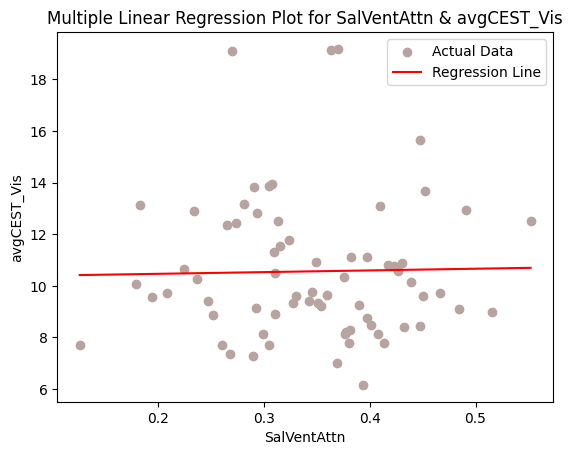

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6432
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.529
Time:                        13:13:04   Log-Likelihood:                -168.15
No. Observations:                  70   AIC:                             342.3
Df Residuals:                      67   BIC:                             349.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0885    

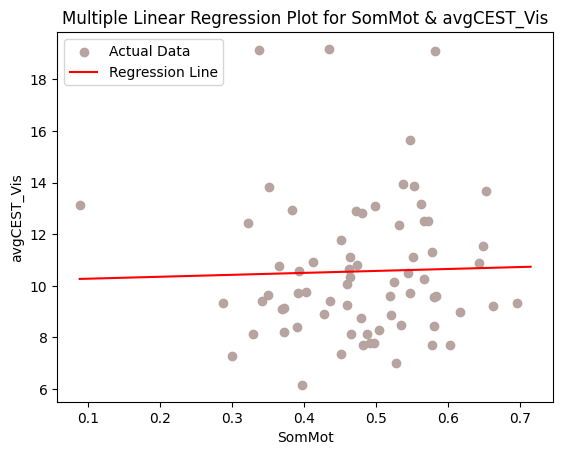

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.784
Date:                Mon, 22 Apr 2024   Prob (F-statistic):             0.0691
Time:                        13:13:04   Log-Likelihood:                -163.86
No. Observations:                  69   AIC:                             333.7
Df Residuals:                      66   BIC:                             340.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6318    

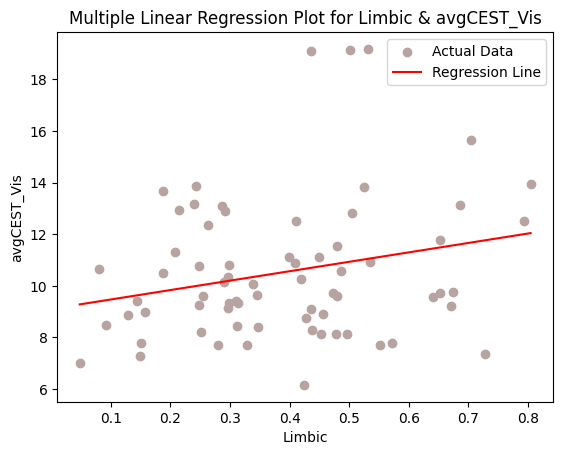

In [41]:
graph_df = grp_df
print(graph_df.columns.tolist())
print("is panda") if type(graph_df) == pd.core.frame.DataFrame else print("not panda")

cestcol='avgCEST_Vis'
network='Vis'

formula = f'{cestcol} ~ {network} + {covariate_age}'
model = smf.ols(formula=formula, data=graph_df).fit()
print('CEST-FC Association in all') 
print(model.summary())

fig, ax = plt.subplots()
ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
# Generate x values for the line
x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                       covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
# Predictions for the regression line
y_line = model.predict(x_line)
# Plot the regression line
ax.plot(x_line[network], y_line, color='red', label='Regression Line')
ax.set_xlabel(network)
ax.set_ylabel(cestcol)
ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
ax.legend()
plt.show()



for network in networks:
    formula = f'{cestcol} ~ {network} + {covariate_age}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('CEST-FC Association in all') 
    print(model.summary())

    fig, ax = plt.subplots()
    ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                           covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[network], y_line, color='red', label='Regression Line')
    ax.set_xlabel(network)
    ax.set_ylabel(cestcol)
    ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
    ax.legend()
    plt.show()
    


Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.681
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.204
Time:                        19:48:44   Log-Likelihood:                -112.77
No. Observations:                  32   AIC:                             231.5
Df Residuals:                      29   BIC:                             235.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

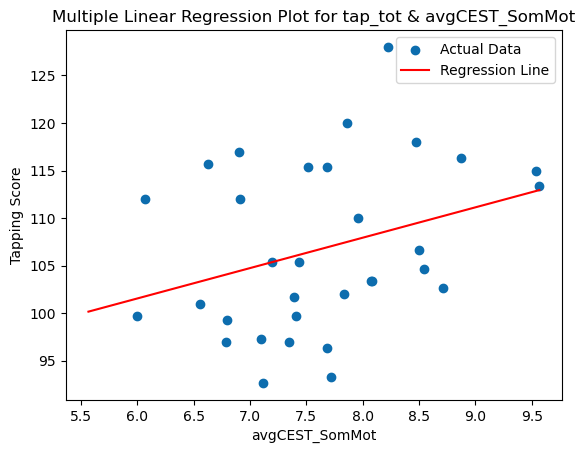

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.4299
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.654
Time:                        19:48:44   Log-Likelihood:                -151.50
No. Observations:                  43   AIC:                             309.0
Df Residuals:                      40   BIC:                             314.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

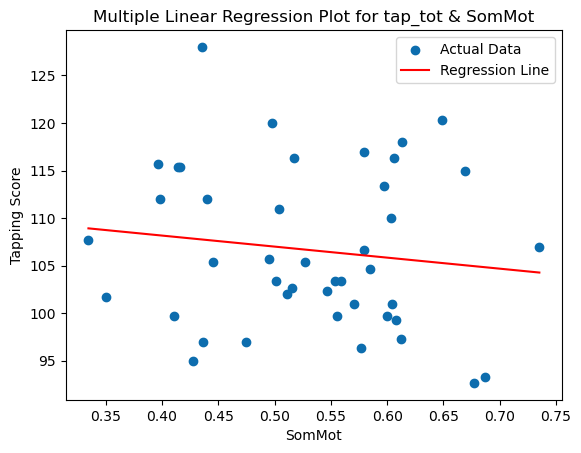

In [8]:
# First, replicate main findings of CEST and FC vs taptot using multiple linear regression to control for age and sex.p
for CNB_score in CNB_scores:
    for metric in metrics: 
        formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('Regression of ' + metric + ' vs taptot in all') 
        print(model.summary())

        fig, ax = plt.subplots()
        ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                               covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
        ax.set_xlabel(metric)
        ax.set_ylabel('Tapping Score')
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
        ax.legend()
        plt.show()





Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                    0.2777
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.763
Time:                        19:48:55   Log-Likelihood:                -48.296
No. Observations:                  14   AIC:                             102.6
Df Residuals:                      11   BIC:                             104.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


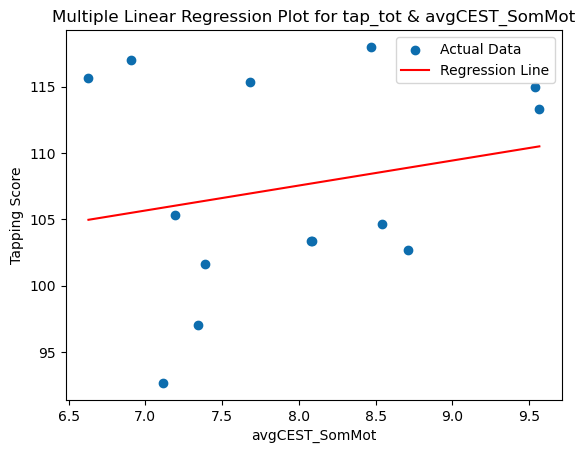

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.5101
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.610
Time:                        19:48:55   Log-Likelihood:                -64.962
No. Observations:                  19   AIC:                             135.9
Df Residuals:                      16   BIC:                             138.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


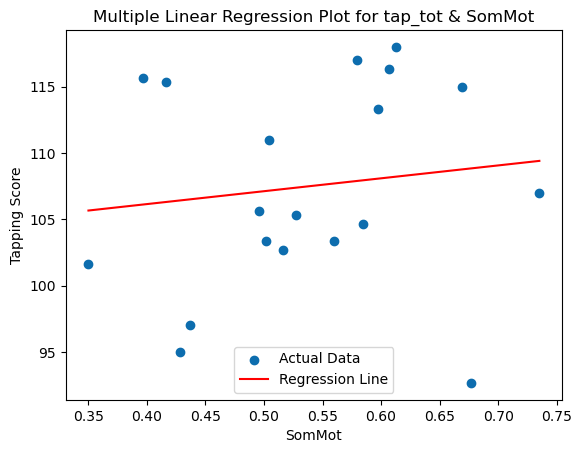

Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.224
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.326
Time:                        19:48:56   Log-Likelihood:                -57.584
No. Observations:                  16   AIC:                             121.2
Df Residuals:                      13   BIC:                             123.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


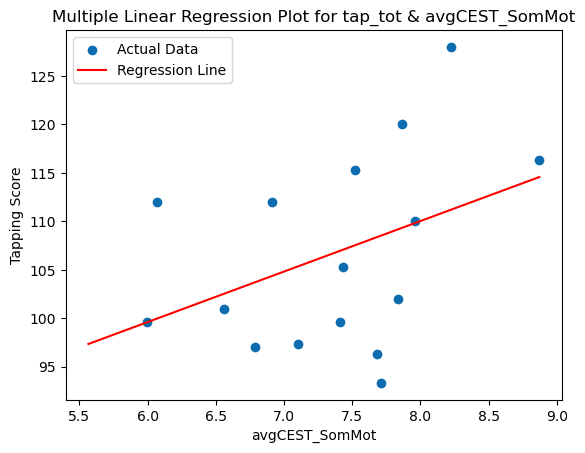

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.690
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.211
Time:                        19:48:56   Log-Likelihood:                -77.772
No. Observations:                  22   AIC:                             161.5
Df Residuals:                      19   BIC:                             164.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

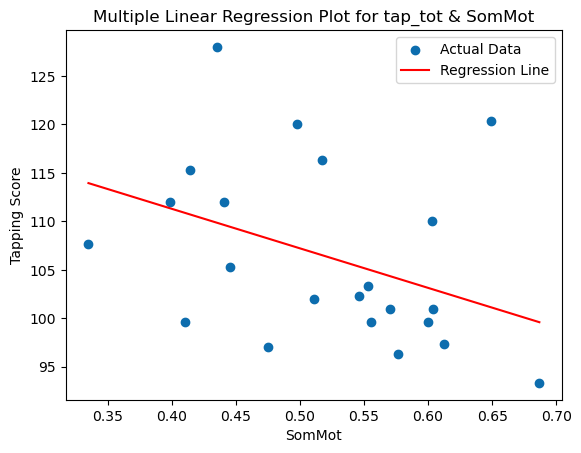

In [9]:
# Regression by hstatus of CEST and FC versus Tapping Score.
statuses = ['HC', 'PSY']
# Create a figure outside the loop to have a single plot
#fig, ax = plt.subplots()

for status in statuses:
    for metric in metrics:
        for CNB_score in CNB_scores:
            ##################################
            graph_df = grp_df[grp_df['hstatus'] == status]
            # Define formula and model
            formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
            model = smf.ols(formula=formula, data=graph_df).fit()
            print('Regression of ' + metric + ' vs taptot in all') 
            print(model.summary())

            fig, ax = plt.subplots()
            ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
            # Generate x values for the line
            x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                                   covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
            # Predictions for the regression line
            y_line = model.predict(x_line)
            # Plot the regression line
            ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
            ax.set_xlabel(metric)
            ax.set_ylabel('Tapping Score')
            ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
            ax.legend()
            plt.show()





Vis & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.263
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.296
Time:                        11:54:52   Log-Likelihood:                -133.01
No. Observations:                  37   AIC:                             272.0
Df Residuals:                      34   BIC:                             276.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     121.4026      9.300

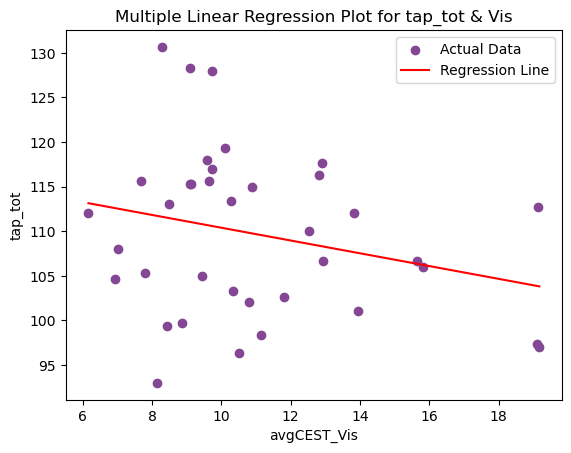

In [13]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Multiple linear regression predicting TapTot using SomMot and FC
#for network in networks:
    
network = "Vis"    
    
cestcol = "avgCEST_" + network
# Create a linear regression model for fcon

# Create CNB correlation plot for each network fcon and cest 
for CNB_score in CNB_scores:
 #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
    graph_df = graph_df[[CNB_score, cestcol, network]]
    # Define x values and target variable
    X = graph_df[[cestcol, network]]
    Y = graph_df[CNB_score]

    ##################################
    # Define formula and model
    formula = f'{CNB_score} ~ {cestcol} + {network}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('\n\n\n' + network + ' & ' + CNB_score) 
    print(model.summary())

    # Plotting the regression line
    fig, ax = plt.subplots()
    ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                           network: np.mean(graph_df[network])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
    ax.set_xlabel(cestcol)
    ax.set_ylabel(CNB_score)
    ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
    ax.legend()
    plt.show()

### 3D Plot Troubleshooting

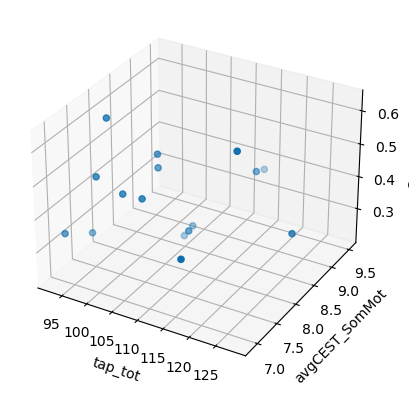

In [14]:
# BBS
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
        ax.set_xlabel(CNB_score)
        ax.set_ylabel(cestcol)
        ax.set_zlabel(network)
        plt.show()

In [ ]:
###Save Output

In [16]:
!jupyter nbconvert --to html motor_figures.ipynb --output motor_figures_7T.html

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook motor_figures.ipynb to html
[NbConvertApp] Writing 1602776 bytes to motor_figures_7T.html
